<a href="https://colab.research.google.com/github/sheemambabu/CMPE-297-Special-Topics/blob/main/Assignment_1/Assignment_1_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CMPE: 297 Special Topics
# Assignment-1: Implement simclr in PyTorch
# By: Sheema Murugesh Babu (SJSU-ID: 015217176)

## Importing the necessary libraries

In [ ]:
# Basic Imports

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# PyTorch Imports

import torch.nn as nn
import torchvision.transforms as transforms

In [ ]:
# Image Manipulation imports

from PIL import Image
from collections import OrderedDict, namedtuple

## Imagenet Dataset download

In [ ]:
!gdown https://drive.google.com/uc?id=1x3BSoqoe76FcWdbagLj6Mx6_2EAJ982g

Downloading...
From: https://drive.google.com/uc?id=1x3BSoqoe76FcWdbagLj6Mx6_2EAJ982g
To: /content/milli_imagenet.zip
92.9MB [00:00, 164MB/s]


In [ ]:
# Zipping the file

import zipfile

with zipfile.ZipFile('milli_imagenet.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/')

# Displaying the contents of the file

!cat milli_imagenet/mapper.json

{"car": 0, "airplane": 1, "elephant": 2, "dog": 3, "cat": 4}


## Utility Functions

In [ ]:
# NT-Xent Loss Function

tau = 0.05

# Function that calculates NT-Xent
def loss_function(a, b):
    a_norm = torch.norm(a, dim=1).reshape(-1, 1)
    a_cap = torch.div(a, a_norm)
    b_norm = torch.norm(b, dim=1).reshape(-1, 1)
    b_cap = torch.div(b, b_norm)
    a_cap_b_cap = torch.cat([a_cap, b_cap], dim=0)
    a_cap_b_cap_transpose = torch.t(a_cap_b_cap)
    b_cap_a_cap = torch.cat([b_cap, a_cap], dim=0)
    sim = torch.mm(a_cap_b_cap, a_cap_b_cap_transpose)
    sim_by_tau = torch.div(sim, tau)
    exp_sim_by_tau = torch.exp(sim_by_tau)
    sum_of_rows = torch.sum(exp_sim_by_tau, dim=1)
    exp_sim_by_tau_diag = torch.diag(exp_sim_by_tau)
    numerators = torch.exp(torch.div(torch.nn.CosineSimilarity()(a_cap_b_cap, b_cap_a_cap), tau))
    denominators = sum_of_rows - exp_sim_by_tau_diag
    num_by_den = torch.div(numerators, denominators)
    neglog_num_by_den = -torch.log(num_by_den)
    return torch.mean(neglog_num_by_den)

In [ ]:
# Loss Function Plotting

def plot_losses(arr, legend_name):
    plt.figure(figsize=(10, 10))
    sns.set_style('darkgrid')
    plt.plot(arr)
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.show()

## Training

In [ ]:
import torch

class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, args):
        self.args = args
        with open(os.path.join(args.datapath, "train","names.txt")) as f:
            self.filenames = f.read().split('\n')
 
    def __len__(self):
        return len(self.filenames)

    def tensorify(self, img):
        return transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(
            transforms.ToTensor()(img)
            )
    # Produces distortion in colors based on arguments 
    def get_color_distortion(self, s=1.0):
        color_jitter = transforms.ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s)
        rnd_color_jitter =  transforms.RandomApply([color_jitter], p=0.8)
        rnd_gray =  transforms.RandomGrayscale(p=0.2)
        color_distort =  transforms.Compose([rnd_color_jitter, rnd_gray])
        return color_distort

    # Aids in augmentation of images
    def augmented_image(self, img):
        return self.get_color_distortion(1)(
            transforms.RandomResizedCrop(224)(img)
            )    

    def __getitem__(self, idx):
        img = transforms.Resize((224, 224))(
                                Image.open(os.path.join(args.datapath, 'train', self.filenames[idx])).convert('RGB')
                            )
        return {
        'image1':self.tensorify(
            self.augmented_image(img)
            ), 
        'image2': self.tensorify(
            self.augmented_image(img)
            )
        }

## ResNet Model

In [ ]:
from torchvision.models import resnet18

def get_model(args):
    resnet = resnet18(pretrained=False)

    classifier = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(resnet.fc.in_features, 100)),
        ('added_relu1', nn.ReLU(inplace=True)),
        ('fc2', nn.Linear(100, 100)),
        ('added_relu2', nn.ReLU(inplace=True)),
        ('fc3', nn.Linear(100, 100))
    ]))

    resnet.fc = classifier

    if args.multiple_gpus:
        resnet = nn.DataParallel(resnet)

    resnet.to(args.device)

    return resnet

## SimCLR Training loop

In [ ]:
class SimCLR:
    def __init__(self, model, optimizer, dataloaders, loss_fn):
        self.model = model
        self.optimizer = optimizer
        self.dataloaders = dataloaders
        self.loss_fn = loss_fn

    def train(self, args, num_epochs, log_interval):
        batch_losses = []

        self.model.train()
    
        # run a for loop for num_epochs
        for epoch in range(num_epochs):

            # run a for loop for each batch
            for step, batch in enumerate(self.dataloaders['train']):
                # zero out grads
                self.optimizer.zero_grad()

                x1 = batch['image1'].to(args.device)
                x2 = batch['image2'].to(args.device)

                # get their outputs
                y1 = self.model(x1)
                y2 = self.model(x2)

                # get loss value
                loss = self.loss_fn(y1, y2)

                batch_losses.append(loss.cpu().data.item())

                # perform backprop on loss value to get gradient values
                loss.backward()

                # run the optimizer
                self.optimizer.step()
                
                if step % log_interval == 0:
                    print(f'Epoch: {epoch} / {num_epochs} Step: {step} Loss: {loss.item()}')
                
                if step >= 5:
                  break
            
        plot_losses(batch_losses, 'Training Losses')

## SimCLR: Run

1250 images are being trained!


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 0 / 50 Step: 0 Loss: 2.1641881465911865
Epoch: 0 / 50 Step: 5 Loss: 1.6998306512832642
Epoch: 1 / 50 Step: 0 Loss: 1.4341919422149658
Epoch: 1 / 50 Step: 5 Loss: 3.1036179065704346
Epoch: 2 / 50 Step: 0 Loss: 2.1740825176239014
Epoch: 2 / 50 Step: 5 Loss: 2.213608503341675
Epoch: 3 / 50 Step: 0 Loss: 2.100639820098877
Epoch: 3 / 50 Step: 5 Loss: 2.178079128265381
Epoch: 4 / 50 Step: 0 Loss: 2.2445876598358154
Epoch: 4 / 50 Step: 5 Loss: 2.2679905891418457
Epoch: 5 / 50 Step: 0 Loss: 2.2541544437408447
Epoch: 5 / 50 Step: 5 Loss: 2.1851871013641357
Epoch: 6 / 50 Step: 0 Loss: 2.3266541957855225
Epoch: 6 / 50 Step: 5 Loss: 2.1280016899108887
Epoch: 7 / 50 Step: 0 Loss: 2.0651729106903076
Epoch: 7 / 50 Step: 5 Loss: 2.0666632652282715
Epoch: 8 / 50 Step: 0 Loss: 2.097670793533325
Epoch: 8 / 50 Step: 5 Loss: 2.3685600757598877
Epoch: 9 / 50 Step: 0 Loss: 2.6970417499542236
Epoch: 9 / 50 Step: 5 Loss: 2.236569881439209
Epoch: 10 / 50 Step: 0 Loss: 2.282827854156494
Epoch: 10 / 50 Ste

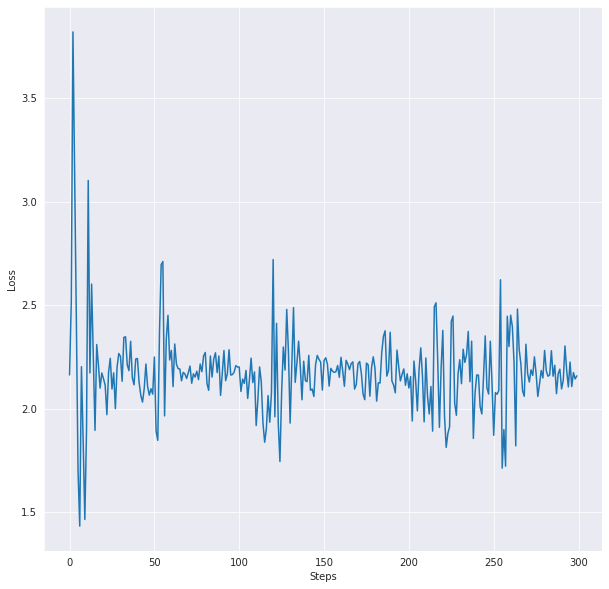

In [ ]:
args = {
    'datapath': '/content/milli_imagenet',
    'cuda': False,
    'batch_size': 5,
    'num_workers': 2,
    'multiple_gpus': False,
}
args['device'] = torch.device('cuda' if args['cuda'] else 'cpu')
args = namedtuple('Args', args.keys())(*args.values())

model = get_model(args)

optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=0.001, 
    weight_decay=1e-4
    )

dataloaders = {}
ds = TrainDataset(args)
print(f'{len(ds)} images are being trained!')

dataloaders['train'] = torch.utils.data.DataLoader(
    ds, 
    batch_size=args.batch_size, 
    shuffle=True, 
    num_workers=args.num_workers
    )

loss_fn = loss_function
simclrobj = SimCLR(model, optimizer, dataloaders, loss_fn)
simclrobj.train(args, 50, 5)